# Ex05 네이버 영화리뷰 감성분석

## 1. 데이터 준비와 확인

In [3]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [4]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 로더

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

    # 문장을 토큰화한 후 불용어를 제거하여 리스트로 변환
    train_sentences = list(train_data['document'] # 훈련 세트
                           .apply(lambda x: tokenizer.morphs(x)) # 토큰화
                           .apply(lambda x: [item for item in x if item not in stopwords])) # 불용어 제거
    test_sentences = list(test_data['document'] # 테스트 세트
                          .apply(lambda x: tokenizer.morphs(x)) # 토큰화
                          .apply(lambda x: [item for item in x if item not in stopwords])) # 불용어 제거

    # 각 토큰을 words 리스트에 담는다.
    words = []
    for sentence in train_sentences: # train 속 단어
        words.extend(sentence)
    for sentence in test_sentences: # test 속 단어
        words.extend(sentence)

    # 상위 10000개의 단어만을 선택한다.
    counter = Counter(words).most_common(10000 - 4)
    #print(counter)

    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    # 문장 속 단어를 인덱스에 매핑해준다.
    X_train = list(map(wordlist_to_indexlist, train_sentences))
    y_train = np.array(train_data['label'])
    X_test = list(map(wordlist_to_indexlist, test_sentences))
    y_test = np.array(test_data['label'])
    return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(word_to_index))

146182
146182
49157
49157
10000


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
# 테스트

get_decoded_sentence(X_train[1], index_to_word)

'. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나'

##  모델 구성을 위한 데이터 분석 및 가공

평균: 15.98170773419436 표준편차: 12.82473766384545


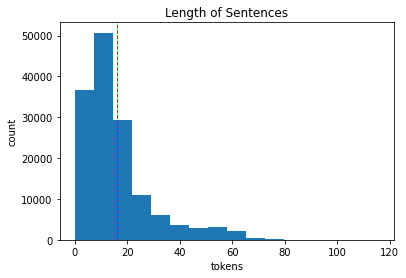

In [10]:
# 문장 내 토큰 길이 분포 보기
import matplotlib.pyplot as plt
import math

token_lens = [len(sentence) for sentence in X_train]
plt.hist(token_lens, bins = 16)
plt.xlabel('tokens')
plt.ylabel('count')
plt.title('Length of Sentences')

# draw a line at average
plt.axvline(x=np.mean(token_lens), color='r', linestyle='dashed', linewidth=1)
print(f"평균: {np.mean(token_lens)} 표준편차: {np.std(token_lens)}")


plt.show()

In [11]:
# 평균 길이: 16
# 표준편차 : 13

maxlen = 40 # 설정할 최대 길이 40

# import keras.preprocessing.sequence.pad_sequences
from keras.preprocessing.sequence import pad_sequences
padded_X_train = pad_sequences(X_train, maxlen=maxlen, padding='pre')
padded_X_test = pad_sequences(X_test, maxlen=maxlen, padding='pre')

## 모델 구성 및 validation set 구성

In [12]:
# Validation set 구성
# 기존 훈련 세트를 쪼개서 훈련 세트와 검증 세트로 분할한다.
split_ratio = int(padded_X_train.shape[0] * 0.8) # 8:2 비율로 분할한다.

final_X_train, final_X_val = padded_X_train[:split_ratio], padded_X_train[split_ratio:]
final_y_train, final_y_val = y_train[:split_ratio], y_train[split_ratio:]

print(f"final_X_train.shape: {final_X_train.shape}")
print(f"final_y_train.shape: {final_y_train.shape}")
print(f"final_X_val.shape: {final_X_val.shape}")
print(f"final_y_val.shape: {final_y_val.shape}")

final_X_train.shape: (116945, 40)
final_y_train.shape: (116945,)
final_X_val.shape: (29237, 40)
final_y_val.shape: (29237,)


In [13]:
# 모델 구성
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 무슨 모델이 좋을까?
# Conv1D, LSTM, GRU이렇게 써보자.
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 128   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.

In [14]:
conv_model = Sequential(
    [
        layers.Embedding(len(word_to_index), word_vector_dim),
        layers.Conv1D(16, 3, activation="relu"),
        layers.GlobalMaxPooling1D(),
        layers.Dense(1, activation="sigmoid")
    ]
)

lstm_model = Sequential(
    [
        layers.Embedding(len(word_to_index), word_vector_dim),
        layers.LSTM(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

gru_model = Sequential(
    [
        layers.Embedding(len(word_to_index), word_vector_dim),
        layers.GRU(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

In [223]:
conv_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
gru_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 모델 훈련 개시

In [224]:
conv_history = conv_model.fit(
    final_X_train,
    final_y_train,
    epochs=5,
    batch_size=32,
    validation_data=((final_X_val), (final_y_val))  # Add validation set here
)

lstm_history = lstm_model.fit(
    final_X_train,
    final_y_train,
    epochs=5,
    batch_size=32,
    validation_data=((final_X_val), (final_y_val))  # Add validation set here
)

gru_history = gru_model.fit(
    final_X_train,
    final_y_train,
    epochs=5,
    batch_size=32,
    validation_data=((final_X_val), (final_y_val))  # Add validation set here
)

Epoch 1/5
3655/3655 [==============================] - 14s 4ms/step - loss: 0.2673 - accuracy: 0.8892 - val_loss: 0.3550 - val_accuracy: 0.8563
Epoch 2/5
3655/3655 [==============================] - 13s 4ms/step - loss: 0.1708 - accuracy: 0.9343 - val_loss: 0.3992 - val_accuracy: 0.8502
Epoch 3/5
3655/3655 [==============================] - 13s 4ms/step - loss: 0.1249 - accuracy: 0.9550 - val_loss: 0.4670 - val_accuracy: 0.8453
Epoch 4/5
3655/3655 [==============================] - 14s 4ms/step - loss: 0.0961 - accuracy: 0.9660 - val_loss: 0.5278 - val_accuracy: 0.8387
Epoch 5/5
3655/3655 [==============================] - 14s 4ms/step - loss: 0.0749 - accuracy: 0.9746 - val_loss: 0.6042 - val_accuracy: 0.8373


## Loss, Accuracy 그래프 시각화

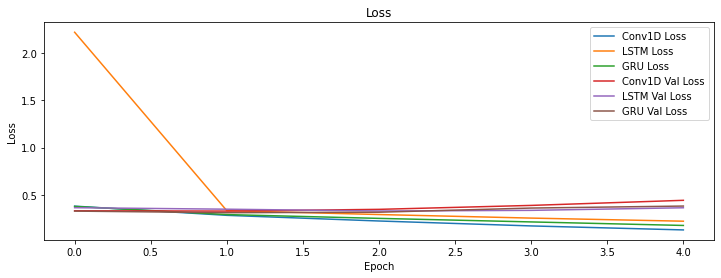

In [130]:
# Visualize loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(conv_history.history['loss'], label='Conv1D Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Loss')
plt.plot(gru_history.history['loss'], label='GRU Loss')
plt.plot(conv_history.history['val_loss'], label='Conv1D Val Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


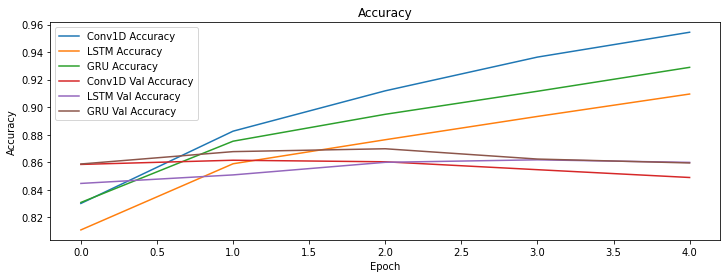

In [131]:
#visualize accuracy
plt.figure(figsize=(12, 4))
plt.plot(conv_history.history['accuracy'], label='Conv1D Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Accuracy')
plt.plot(gru_history.history['accuracy'], label='GRU Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Conv1D Val Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [256]:
# 모델의 최종 성능 확인하기
# 테스트 세트를 사용함
print(f"conv1D 모델의 Accuracy: {conv_model.evaluate(padded_X_test, y_test)[1]}")
print(f"LSTM 모델의 Accuracy: {lstm_model.evaluate(padded_X_test, y_test)[1]}")
print(f"GRU Accuracy: {gru_model.evaluate(padded_X_test, y_test)[1]}")

1537/1537 [==============================] - 3s 2ms/step - loss: 0.6101 - accuracy: 0.8338
conv1D 모델의 Accuracy: 0.8337571620941162
1537/1537 [==============================] - 11s 7ms/step - loss: 0.3731 - accuracy: 0.8567
LSTM 모델의 Accuracy: 0.8566836714744568
1537/1537 [==============================] - 12s 8ms/step - loss: 0.3847 - accuracy: 0.8587
GRU Accuracy: 0.8586976528167725


## 학습된 embedding layer 분석

In [189]:
model = conv_model

In [190]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [191]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/my-embedding.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, 128))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [245]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

my_word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = my_word_vectors['재미']
vector

array([-0.15103143,  0.19986501, -0.06942774,  0.00749561, -0.04567439,
        0.16409817,  0.19846734,  0.0550456 ,  0.09106716,  0.00217222,
       -0.0078209 , -0.113345  , -0.01981571, -0.00288536, -0.03656545,
       -0.00370429,  0.05623198, -0.07319062, -0.15948072, -0.11161423,
        0.10248981, -0.00257162, -0.06474182,  0.08995298,  0.10317146,
        0.06980935,  0.24956441, -0.00804462, -0.06042767,  0.08354449,
       -0.15514688, -0.07780403, -0.0010478 ,  0.24719484,  0.09927498,
        0.06731019, -0.11344356,  0.08576212,  0.23677954, -0.03286676,
       -0.191049  , -0.07764528,  0.0083264 , -0.33160648,  0.1428481 ,
       -0.02320308, -0.01426934,  0.01804603,  0.05158601,  0.05484661,
       -0.11720053,  0.01289381, -0.07336015, -0.13001756, -0.10596491,
       -0.12592119, -0.01335002, -0.05207836, -0.00323619,  0.11833824,
       -0.08908487,  0.10439941,  0.1487775 ,  0.09273888, -0.17132637,
       -0.04818881, -0.179487  ,  0.02751178, -0.17434588,  0.20

In [193]:
# 임베딩 속 단어를 살펴보는 함수를 만들기
def lookup_similar_words(word_vectors, word):
    try:
        result = [word[0] for word in word_vectors.similar_by_word(word)]
    except:
        result = f"{word}: 해당 단어는 없습니다."
        print(result)
        return;
    print(f"'{word}'의 유사어:", end=" ")
    print(result)

In [246]:
# 자체학습 임베딩의 단어 살펴보기
print("\n### 자체학습 임베딩의 긍정적인 단어들")
lookup_similar_words(my_word_vectors, "재미")
lookup_similar_words(my_word_vectors,"강추")
lookup_similar_words(my_word_vectors,"추천")
lookup_similar_words(my_word_vectors,"감동")

print("\n### 자체학습 임베딩의 부정적인 단어들")
lookup_similar_words(my_word_vectors,"비추")
lookup_similar_words(my_word_vectors,"짜증")
lookup_similar_words(my_word_vectors,"쓸데없")
lookup_similar_words(my_word_vectors,"최악")

print("\n### 자체학습 임베딩의 중립적인 단어들")
lookup_similar_words(my_word_vectors,"별점")
lookup_similar_words(my_word_vectors,"각본")
lookup_similar_words(my_word_vectors,"연기")
lookup_similar_words(my_word_vectors,"배우")


### 자체학습 임베딩의 긍정적인 단어들
'재미'의 유사어: ['엠마', '젬', '브금', '희열', '내려놓', '철학', '숨죽이', '쪙', '폐인', '행운']
'강추'의 유사어: ['^.^', '>.<', '><', '두려움', '♡', '바르뎀', '겸손', '슬퍼요', '웰메이드', '빛난다']
'추천'의 유사어: ['쏠쏠', '귀여워', '과소평가', '오늘', '정점', '쩐', '♥', '아름다워요', '메마른', '굳']
'감동'의 유사어: ['뜨겁', '인연', '끝장', '슬픔', '최수종', '마음', '어우러져', 'It', '젬', '숨죽이']

### 자체학습 임베딩의 부정적인 단어들
'비추'의 유사어: ['.-_-;;', '충동', '든가', '개콘', '.,,', '지겨워서', '오그라들', '바꿔서', '모야', '놔서']
'짜증'의 유사어: ['자빠졌', '모야', '최시원', '동남아', '산만', '어이', '읍', '차라리', '자질', '영점']
'쓸데없'의 유사어: ['이용', '어장', '납치', '인과', '도로', '우습', '따로', '괴', '무미건조', '도저히']
'최악'의 유사어: ['꺼버렸', '먹칠', '짝퉁', '화났', '꺼버린', '낚시질', '성괴', '유치원생', '하품', '쓰레']

### 자체학습 임베딩의 중립적인 단어들
'별점'의 유사어: ['좌파', '카피', '???', '쌈', '단다', '호모', '떨어지', '제로', '적합', '듣보잡']
'각본'의 유사어: ['금포', '패기', '상투', '돌렸', '욕했', '뻔했', '건너', '투성이', '눈길', '바닥']
'연기'의 유사어: ['가르쳐', '대중', '무민', '김소연', '극장판', '돌아갈', '스런', '조크', '직접', '촬영']
'배우'의 유사어: ['소재', '무려', '방', '대표', '씨', '끼리', 'B', '강도', '다는', '아무것']


## 한국어 word2vec 임베딩 활용하여 성능 개선

In [195]:
from gensim.models.keyedvectors import Word2VecKeyedVectors, KeyedVectors
word2vec_ko_path = os.getenv('HOME')+'/data/word2vec_ko.model'
pretrained_word_vectors = KeyedVectors.load(word2vec_ko_path)


In [199]:
pretrained_word_vectors.wv.vector_size

100

In [247]:
# 사전학습 임베딩의 단어 살펴보기
print("\n### 사전학습 임베딩의 긍정적인 단어들")
lookup_similar_words(pretrained_word_vectors.wv, "재미")
lookup_similar_words(pretrained_word_vectors.wv,"강추")
lookup_similar_words(pretrained_word_vectors.wv,"추천")
lookup_similar_words(pretrained_word_vectors.wv,"감동")

print("\n### 사전학습 임베딩의 부정적인 단어들")
lookup_similar_words(pretrained_word_vectors.wv,"비추")
lookup_similar_words(pretrained_word_vectors.wv,"짜증")
lookup_similar_words(pretrained_word_vectors.wv,"쓸데없")
lookup_similar_words(pretrained_word_vectors.wv,"최악")

print("\n### 사전학습 임베딩의 중립적인 단어들")
lookup_similar_words(pretrained_word_vectors.wv,"별점")
lookup_similar_words(pretrained_word_vectors.wv,"각본")
lookup_similar_words(pretrained_word_vectors.wv,"연기")
lookup_similar_words(pretrained_word_vectors.wv,"배우")


### 사전학습 임베딩의 긍정적인 단어들
'재미'의 유사어: ['묘미', '취미', '흥미', '유머', '보람', '즐거움', '개그', '이야기', '연애', '열의']
강추: 해당 단어는 없습니다.
'추천'의 유사어: ['천거', '초빙', '초청', '위촉', '포상', '선출', '소개', '임명', '등용', '추대']
'감동'의 유사어: ['감격', '감탄', '매혹', '매력', '감명', '웃음', '열정', '칭찬', '실망', '슬픔']

### 사전학습 임베딩의 부정적인 단어들
'비추'의 유사어: ['깃들', '맞추', '꿰뚫', '빗대', '물들', '되짚', '파고들', '녹아들', '미루', '스며들']
'짜증'의 유사어: ['웃기', '슬프', '들통', '싫증', '아무렇', '정말', '거짓말', '더럽', '뭔가', '부끄러움']
'쓸데없'의 유사어: ['그저', '헛된', '재밌', '애써', '터무니없', '아무리', '절대로', '달려드', '일부러', '멋대로']
'최악'의 유사어: ['전대미문', '초유', '최고', '희대', '뜻밖', '엄청난', '최저', '역대', '최저치', '유례없']

### 사전학습 임베딩의 중립적인 단어들
'별점'의 유사어: ['만점', '평점', 'chan', 'COOL', '벌점', '메타크리틱', 'mp', 'watchOS', '스코어', '오답']
'각본'의 유사어: ['대본', '극본', '연출', '놀런', '주연', '시나리오', '내레이션', '배역', '원안', '히치콕']
'연기'의 유사어: ['연출', '열연', '캐스팅', '촬영', '데이트', '섭외', '각색', '분장', '립싱크', '출연']
'배우'의 유사어: ['가수', '코미디언', '만화가', '영화배우', '여배우', '연출가', '극작가', '삽화가', '안무가', '무용가']


In [202]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in my_word_vectors:
        embedding_matrix[i] = my_word_vectors[index_to_word[i]]

In [212]:
embedding_matrix[0].shape

(128,)

In [257]:
from tensorflow.keras.initializers import Constant
import tensorflow as tf

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원 수 

# 모델 구성
conv_model_with_pt = Sequential(
    [
        layers.Embedding(len(word_to_index), word_vector_dim, embeddings_initializer=Constant(embedding_matrix), trainable=True),
        layers.LSTM(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ]
)

conv_model_with_pt.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [258]:
# 학습의 진행

conv_model_with_pt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = conv_model_with_pt.fit(final_X_train,
                    final_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(final_X_val, final_y_val),
                    verbose=1)

Epoch 1/5
3655/3655 [==============================] - 260s 71ms/step - loss: 0.3652 - accuracy: 0.8540 - val_loss: 0.3211 - val_accuracy: 0.8624
Epoch 2/5
3655/3655 [==============================] - 252s 69ms/step - loss: 0.2590 - accuracy: 0.8932 - val_loss: 0.3210 - val_accuracy: 0.8660
Epoch 3/5
3655/3655 [==============================] - 252s 69ms/step - loss: 0.2149 - accuracy: 0.9134 - val_loss: 0.3256 - val_accuracy: 0.8643
Epoch 4/5
3655/3655 [==============================] - 251s 69ms/step - loss: 0.1741 - accuracy: 0.9318 - val_loss: 0.3595 - val_accuracy: 0.8599
Epoch 5/5
3655/3655 [==============================] - 251s 69ms/step - loss: 0.1400 - accuracy: 0.9463 - val_loss: 0.4343 - val_accuracy: 0.8563


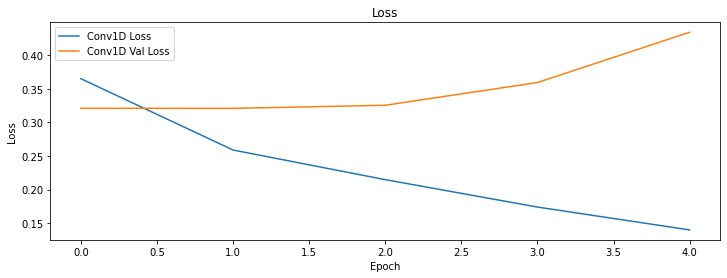

In [259]:
# Visualize loss

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Conv1D Loss')
plt.plot(history.history['val_loss'], label='Conv1D Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

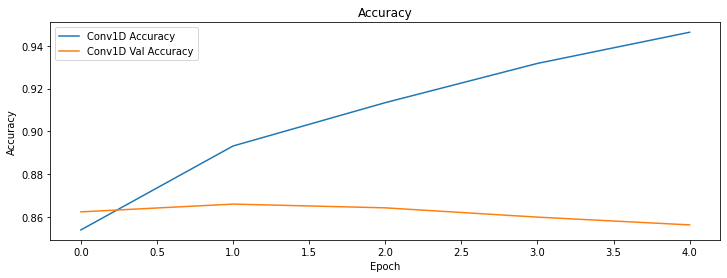

In [260]:
# Visualize accuracy

plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Conv1D Accuracy')
plt.plot(history.history['val_accuracy'], label='Conv1D Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [264]:
# 테스트셋을 통한 모델 평가
results = conv_model_with_pt.evaluate(padded_X_test, y_test)

print(results[1])

1537/1537 [==============================] - 11s 7ms/step - loss: 0.4471 - accuracy: 0.8535
0.8534694910049438


### 결과 살펴보기
자체학습한 임베딩을 사용한 LSTM 모델과 사전학습된 임베딩을 사용한 LSTM 모델을 비교해보았다. 임베딩을 제외한 두 모델의 다른 조건들은 모두 동일하다.
 - 자체학습한 임베딩의 LSTM 모델 accuracy: 0.8567
 - 사전학습된 임베딩의 LSTM 모델 accuracy: 0.8535
 
현재 accracy는 두 모델에서 크게 차이나지는 않는다. 이제 한 번 모델의 구조를 천천히 바꾸어보며 성능을 올려보자.


In [284]:
final_model = Sequential(
    [
        layers.Embedding(len(word_to_index), word_vector_dim, embeddings_initializer=Constant(embedding_matrix), trainable=True),
        layers.LSTM(128, activation="relu", dropout=0.2),
        layers.Dense(1, activation="sigmoid")
    ]
)

final_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = final_model.fit(final_X_train,
                    final_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(final_X_val, final_y_val),
                    verbose=1)

Epoch 1/3
457/457 [==============================] - 36s 76ms/step - loss: 0.4736 - accuracy: 0.8343 - val_loss: 0.3568 - val_accuracy: 0.8489
Epoch 2/3
457/457 [==============================] - 34s 75ms/step - loss: 0.3356 - accuracy: 0.8677 - val_loss: 0.3359 - val_accuracy: 0.8568
Epoch 3/3
457/457 [==============================] - 35s 76ms/step - loss: 0.2863 - accuracy: 0.8818 - val_loss: 0.3265 - val_accuracy: 0.8619


In [285]:
results = final_model.evaluate(padded_X_test, y_test)

print(results[1])

1537/1537 [==============================] - 10s 7ms/step - loss: 0.3342 - accuracy: 0.8585
0.8585145473480225


배치 사이즈와 에포크를 변경하고 드롭아웃을 적용하여 미세하게 성능을 올릴 수 있었다.

하지만, 사전학습된 임베딩으로 극적인 성능 향상은 하지 못한 것이 아쉽다. 결과적으로 임베딩만으로는 모델 성능을 향상시키는 것은 한계가 있는 것 같다고 느낀다. 학습 데이터와 모델의 구조 등의 다른 영향들도 같이 고려해야 성능을 올릴 수 있다고 느낀다.